* 1st :  https://www.kaggle.com/competitions/sartorius-cell-instance-segmentation/discussion/298869
* 2st : https://www.kaggle.com/competitions/sartorius-cell-instance-segmentation/discussion/297988
* 3st : https://www.kaggle.com/competitions/sartorius-cell-instance-segmentation/discussion/298021
* 4st : https://www.kaggle.com/competitions/sartorius-cell-instance-segmentation/discussion/298146

## 1st
* Yolox를 통해서 Bbox를 추출한후 Box후에서 MaskRcnn을 접근을 하였음
* Segmentation과 별개로 2stage로 나뉘어서 접근
* Unalbed data를 활용하여 문제를 접근

## 2St
* 마찬가지로 Detection을 통하여 BBOX를 구한후에 문제 접근\
* pretrained방법으로 새로운 weight로 변경


## 3st


In [2]:
!pip install pycocotools

  Obtaining dependency information for pycocotools from https://files.pythonhosted.org/packages/ba/64/0451cf41a00fd5ac4501de4ea0e395b7d909e09d665e56890b5d3809ae26/pycocotools-2.0.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 6.9 MB/s eta 0:00:00a 0:00:01


In [3]:
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image


dataDir=Path('../input/sartorius-cell-instance-segmentation')
annFile = Path('../input/sartorius-cell-instance-segmentation-coco/annotations_all.json')
coco = COCO(annFile)
imgIds = coco.getImgIds()
imgs = coco.loadImgs(imgIds[-3:])


loading annotations into memory...
Done (t=2.36s)
creating index...
index created!


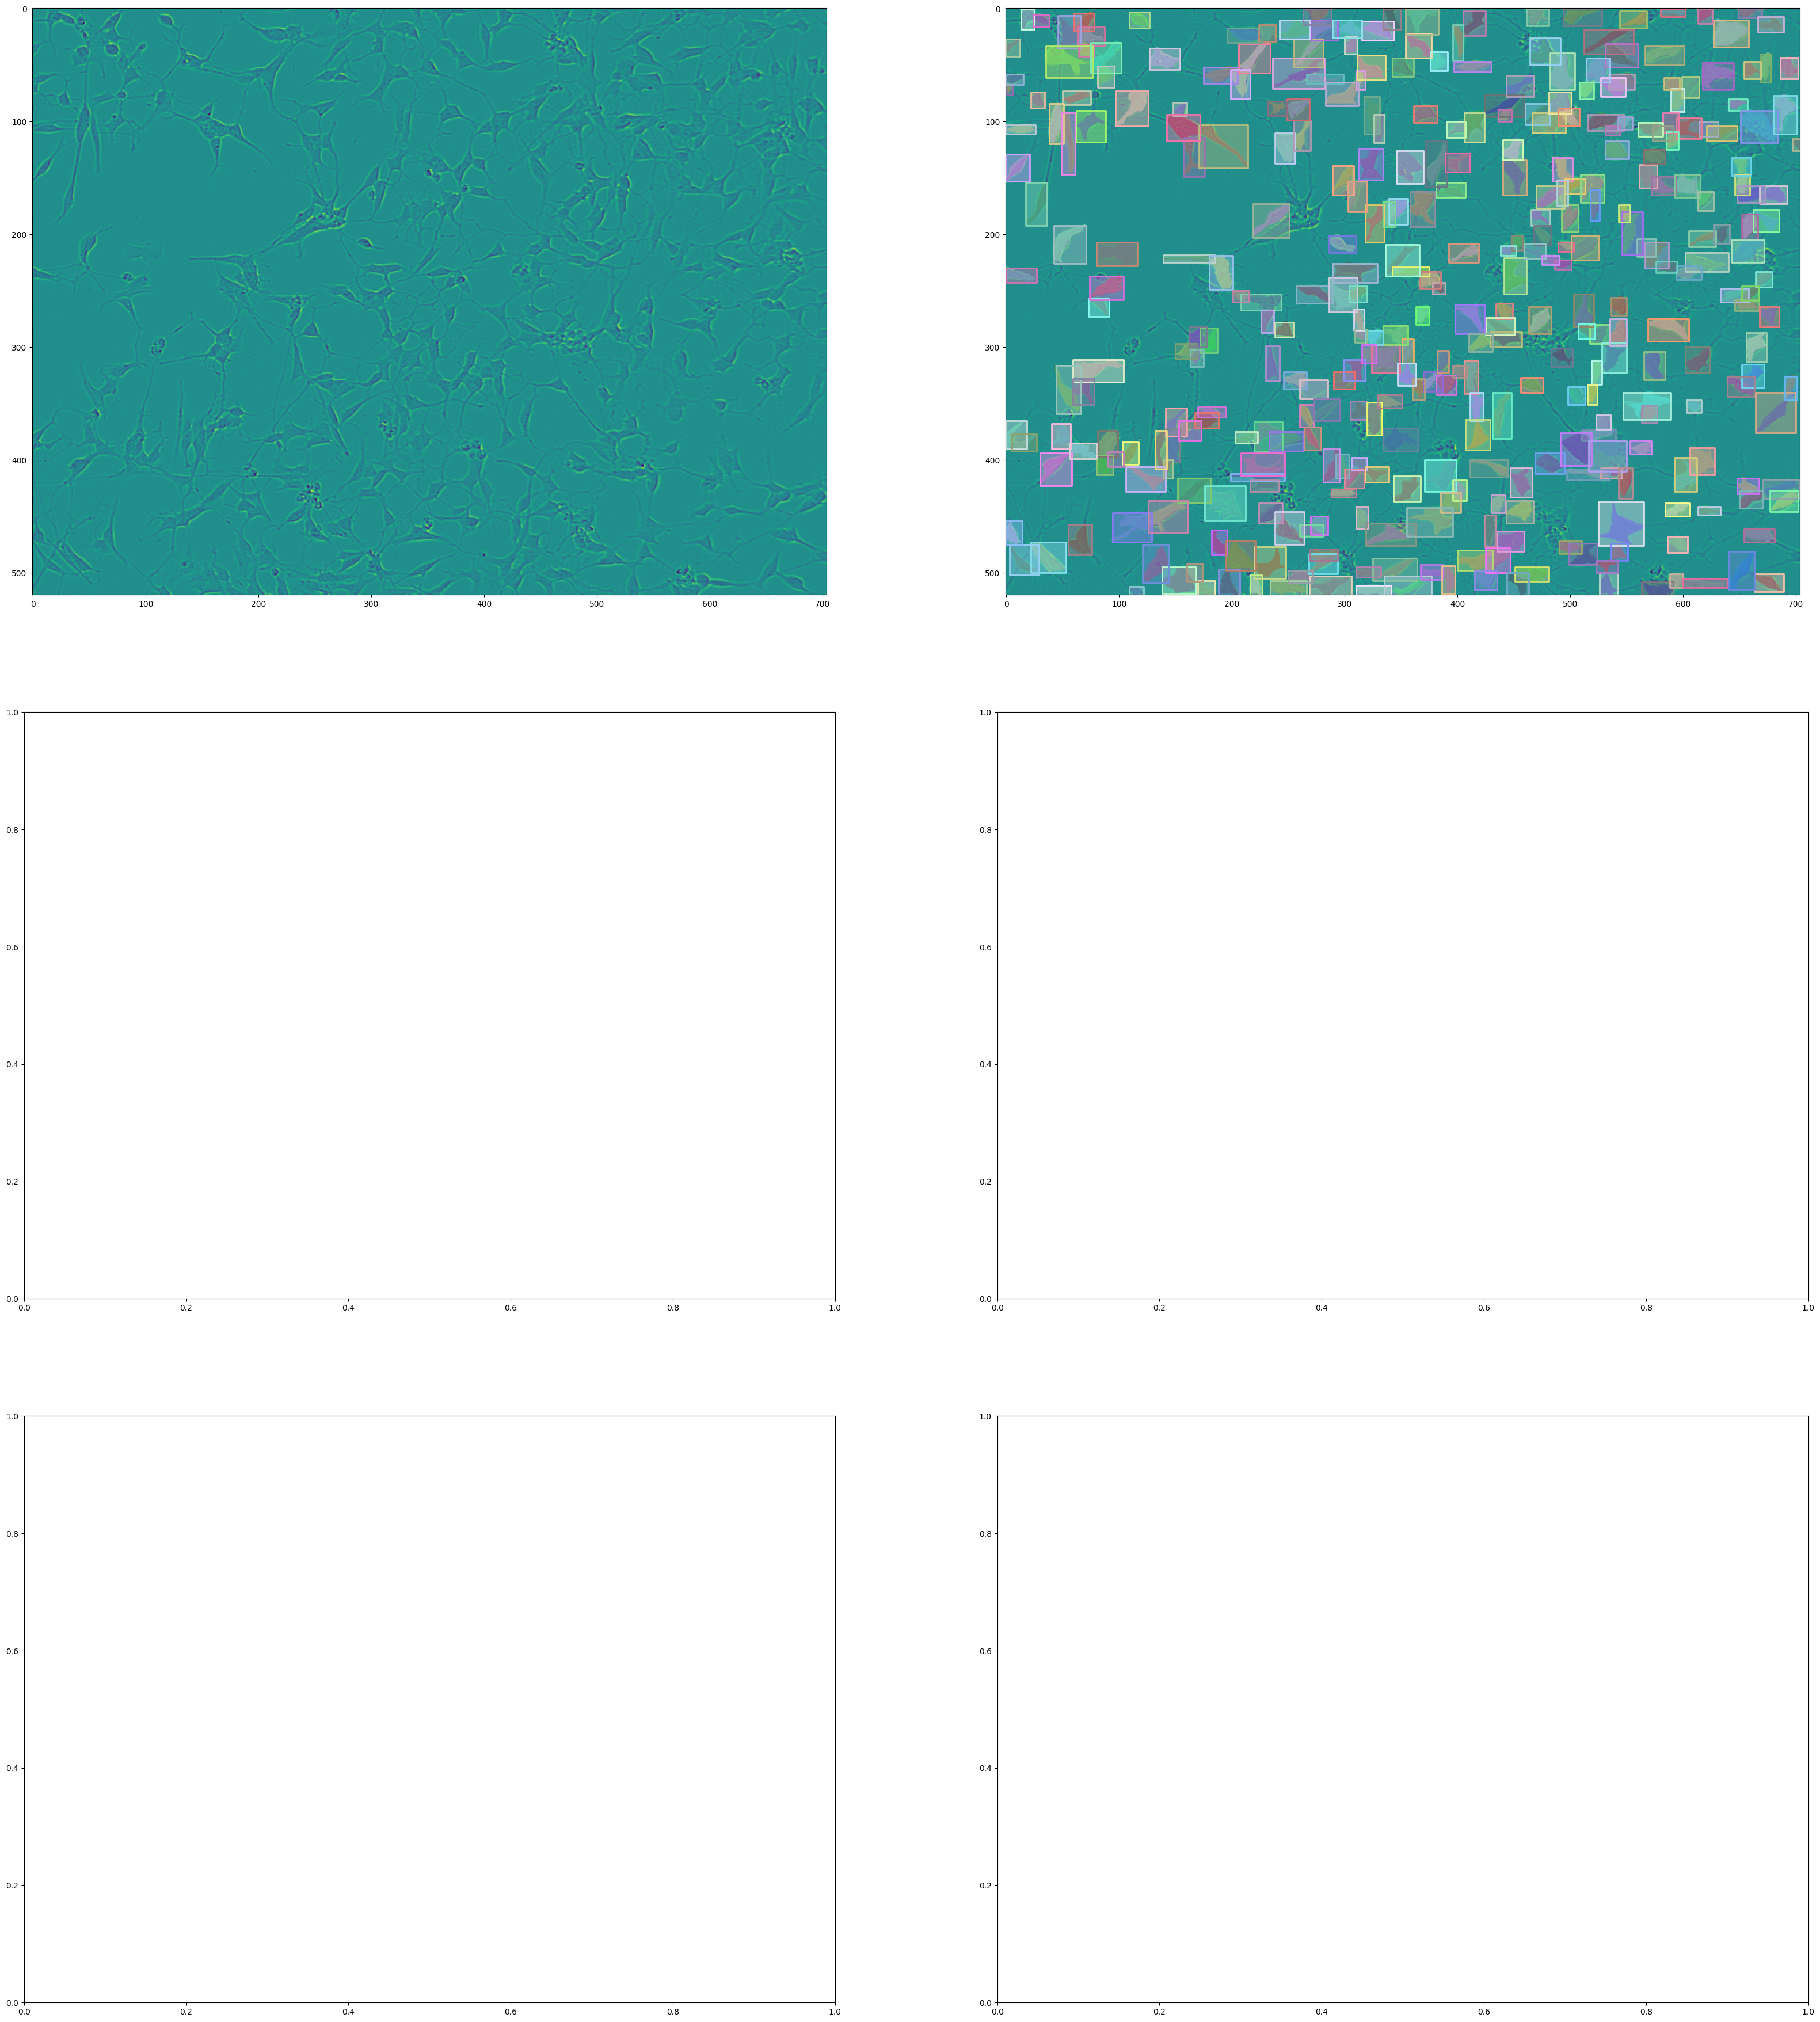

In [4]:
imgs = coco.loadImgs(imgIds[-3:])
_,axs = plt.subplots(len(imgs),2,figsize=(40,15 * len(imgs)))
for img, ax in zip(imgs, axs):
    I = io.imread(dataDir/img['file_name'])
    annIds = coco.getAnnIds(imgIds=[img['id']])
    anns = coco.loadAnns(annIds)
    ax[0].imshow(I)
    ax[1].imshow(I)
    plt.sca(ax[1])
    coco.showAnns(anns, draw_bbox=True)
    
    break 

## 4st
* Classification 사용하여 해당하는 class를 구분 후
* 각각 다른 모델로 학습을 진행
* classification의 경우 cascade-RCNN을 사용하여 구분한다음 instance segmentation을 진행 

In [ ]:
## Weighte box Fusion
def nms_predictions(classes, scores, bboxes, masks, 
                    iou_th=.5, shape=(520, 704)):
    he, wd = shape[0], shape[1]
    boxes_list = [[x[0] / wd, x[1] / he, x[2] / wd, x[3] / he]
                  for x in bboxes]
    scores_list = [x for x in scores]
    labels_list = [x for x in classes]
    nms_bboxes, nms_scores, nms_classes = nms(
        boxes=[boxes_list], 
        scores=[scores_list], 
        labels=[labels_list], 
        weights=None,
        iou_thr=iou_th
    )
    nms_masks = []
    for s in nms_scores:
        nms_masks.append(masks[scores.index(s)])
    nms_scores, nms_classes, nms_masks = zip(*sorted(zip(nms_scores, nms_classes, nms_masks), reverse=True))
    return nms_classes, nms_scores, nms_masks

def ensemble_pred_masks(masks, classes, min_pixels, shape=(520, 704)):
    result = []
    pred_class = max(set(classes), key=classes.count)
    used = np.zeros(shape, dtype=int) 
    for i, mask in enumerate(masks):
        mask = mask * (1 - used)
        if mask.sum() >= min_pixels[pred_class]:
            used += mask
            result.append(rle_encode(mask))
    return result



In [7]:
pip install ensemble-boxes

Note: you may need to restart the kernel to use updated packages.


In [64]:
from ensemble_boxes import *

boxes_list = [[
    [0.00, 0.51, 0.81, 0.91],
    [0.10, 0.31, 0.71, 0.61],
    [0.01, 0.32, 0.83, 0.93],
    [0.02, 0.53, 0.11, 0.94],
    [0.03, 0.24, 0.12, 0.35],
],[
    [0.04, 0.56, 0.84, 0.92],
    [0.12, 0.33, 0.72, 0.64],
    [0.38, 0.66, 0.79, 0.95],
    [0.08, 0.49, 0.21, 0.89],
]]
scores_list = [[0.9, 0.8, 0.2, 0.4, 0.7], [0.5, 0.8, 0.7, 0.3]]
labels_list = [[0, 1, 0, 1, 1], [1, 1, 1, 0]]
weights = [2, 1]

iou_thr = 0.5
skip_box_thr = 0.0001
sigma = 0.1

nms_boxes, nms_scores, nms_labels = nms(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr)
sns_boxes, sns_scores, sns_labels = soft_nms(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, sigma=sigma, thresh=skip_box_thr)
nmw_boxes, nmw_scores, nmw_labels = non_maximum_weighted(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
wbf_boxes, wbf_scores, wbf_labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)

In [65]:
def gen_color_list(model_num, labels_num):
    color_list = np.zeros((model_num, labels_num, 3))
    colors_to_use = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255), (255, 0, 255), (255, 255, 0), (0, 0, 0)]
    total = 0
    for i in range(model_num):
        for j in range(labels_num):
            color_list[i, j, :] = colors_to_use[total]
            total = (total + 1) % len(colors_to_use)
    return color_list


def show_boxes(boxes_list, scores_list, labels_list, image_size=800):
    thickness = 5
    color_list = gen_color_list(len(boxes_list), len(np.unique(labels_list)))
    image = np.zeros((image_size, image_size, 3), dtype=np.uint8)
    image[...] = 255
    for i in range(len(boxes_list)):
        for j in range(len(boxes_list[i])):
            x1 = int(image_size * boxes_list[i][j][0])
            y1 = int(image_size * boxes_list[i][j][1])
            x2 = int(image_size * boxes_list[i][j][2])
            y2 = int(image_size * boxes_list[i][j][3])
            lbl = labels_list[i][j]
            cv2.rectangle(image, (x1, y1), (x2, y2), color_list[i][int(lbl)], int(thickness * scores_list[i][j]))
    return image


In [66]:
nms_boxes, nms_scores, nms_labels = nms(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr)
sns_boxes, sns_scores, sns_labels = soft_nms(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, sigma=sigma, thresh=skip_box_thr)
nmw_boxes, nmw_scores, nmw_labels = non_maximum_weighted(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
wbf_boxes, wbf_scores, wbf_labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)

In [75]:
ori_image = show_boxes([boxes_list[0]], [scores_list[0]], [labels_list[0]])
sec_image = show_boxes([boxes_list[1]], [scores_list[1]], [labels_list[1]])

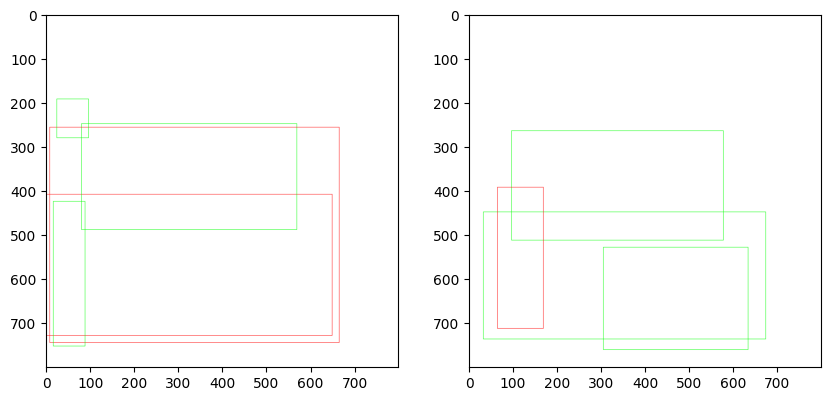

In [78]:
fig,axs = plt.subplots(1,2, figsize=(10,10))
axs[0].imshow(ori_image)
axs[1].imshow(sec_image)

In [79]:
# ori_image = show_boxes(boxes_list, scores_list, labels_list)
nms_image = show_boxes([nms_boxes], [nms_scores], [nms_labels])
sns_image = show_boxes([sns_boxes], [sns_scores], [sns_labels])
nmw_image = show_boxes([nmw_boxes], [nmw_scores], [nmw_labels])
wbf_image = show_boxes([wbf_boxes], [wbf_scores], [wbf_labels])


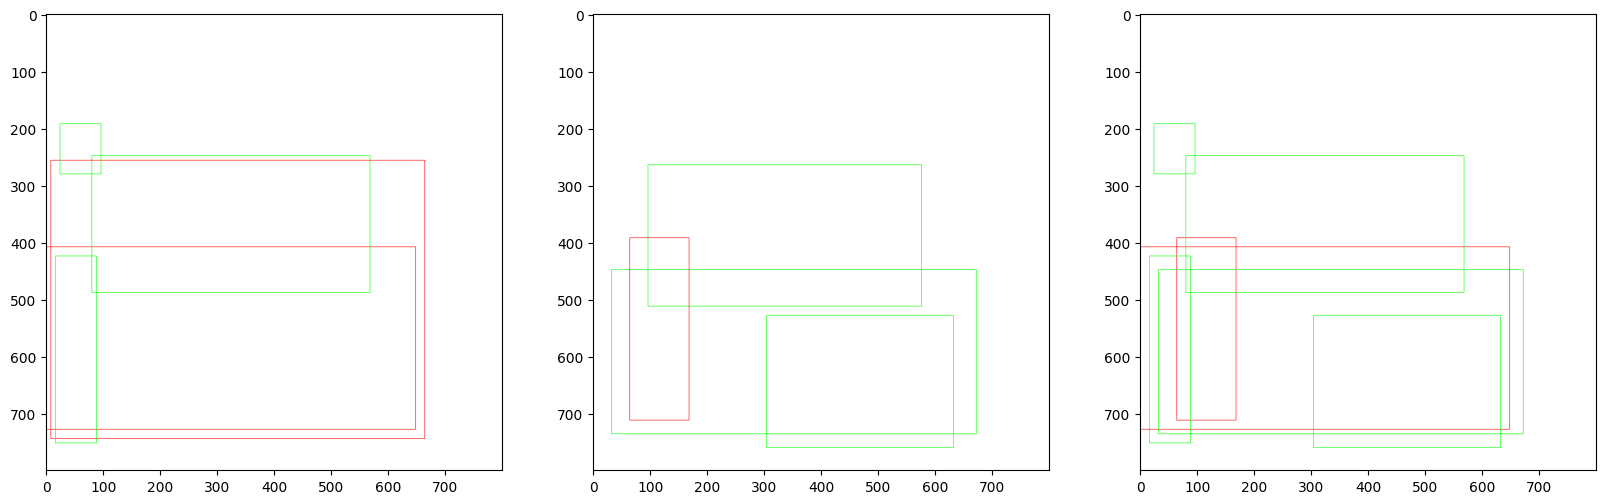

In [82]:
fig,axs = plt.subplots(1,3, figsize=(20,20))
axs[0].imshow(ori_image)
axs[1].imshow(sec_image)
axs[2].imshow(nms_image)

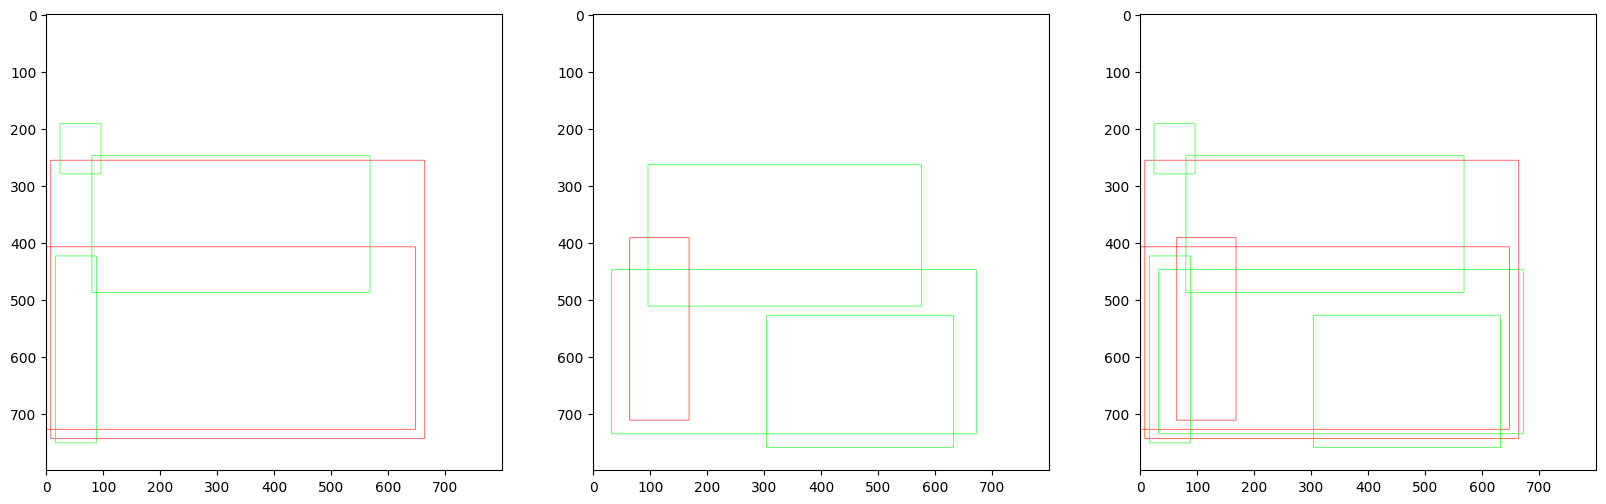

In [83]:
fig,axs = plt.subplots(1,3, figsize=(20,20))
axs[0].imshow(ori_image)
axs[1].imshow(sec_image)
axs[2].imshow(sns_image)

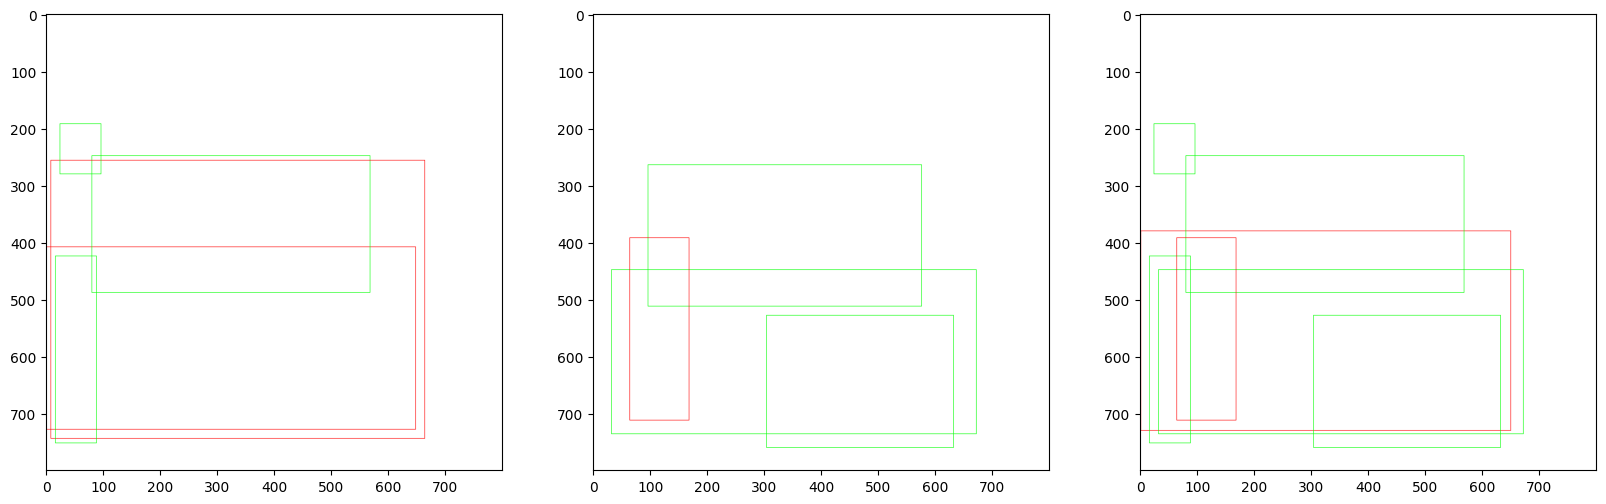

In [84]:
fig,axs = plt.subplots(1,3, figsize=(20,20))
axs[0].imshow(ori_image)
axs[1].imshow(sec_image)
axs[2].imshow(wbf_image)

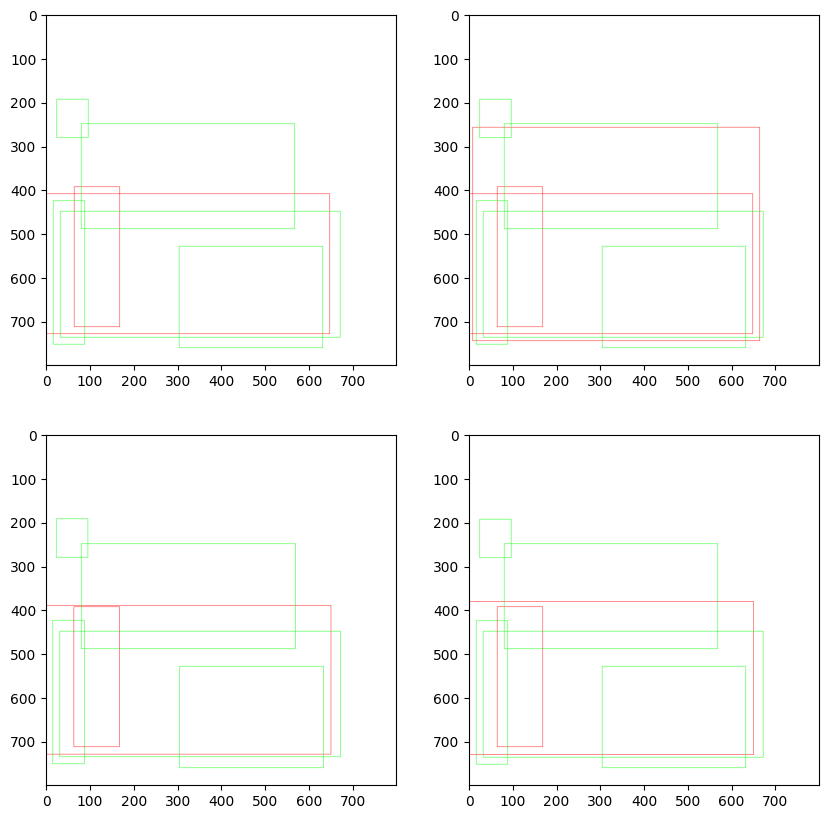

In [85]:
fig,axs = plt.subplots(2,2,figsize=(10,10))
axs[0,0].imshow(nms_image)
axs[0,1].imshow(sns_image)
axs[1,0].imshow(nmw_image)
axs[1,1].imshow(wbf_image)